In [ ]:
!pip install fasttext
!pip install optuna==3.2.0

In [3]:
import optuna
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/Codes /data_labelled.csv"
data = pd.read_csv(data_path, index_col=0)
print(data.shape)
data.head( )

(3596, 4)


,text,label,comment_len,clean_text
id,,,,
131244574,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...,0,27,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...
133141894,دوستان این نظرات و پیشنهادات رو باید به پشتیبا...,0,24,دوستان نظرات پیشنهاد پشتیبان تیک اسنپ فرستاد#ف...
94129372,خیلی ایراد داره مسخره تر از این نمیشه رقیب‌هات...,1,25,ایراد مسخره نمیشه رقیبهات روح ماشین رد میشن ام...
131334220,نه کی گفته خرابه من دارم باهاش کار میکنم از من...,0,20,خرابه با کار رایگانه ممنون سازنده ستاره کمه
131387172,سلام عالیه حتما نصب کنید از کالاف دیوتی هم بهتره,0,10,سلام عالیه نصب کالاف دیوتی بهتره


In [ ]:
data.isna().sum()

text           0
label          0
comment_len    0
clean_text     7
dtype: int64

In [5]:
data.dropna(inplace=True)

In [108]:
from sklearn.model_selection import train_test_split, cross_validate
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'].to_numpy(), data['label'].to_numpy(), test_size=0.2, random_state=42, stratify= data['label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
X_train = tfid.fit_transform(X_train).toarray()
X_test = tfid.transform(X_test).toarray()
X_val = tfid.transform(X_val).toarray()

In [110]:
from sklearn.decomposition import PCA
pca = PCA()
comp = pca.fit(X_train)
y = np.cumsum(comp.explained_variance_ratio_)
x = [i for i in range(len(comp.explained_variance_ratio_))]

print(f"The first {np.round(np.interp(0.8, y, x))} principal components explains about  80% of the variation")
print(f'The first {np.round(np.interp(0.9, y, x))} principal components explains about  90% of the variation')
print(f'The first {np.round(np.interp(0.98, y, x))} principal components explains about 98% of the variation')

The first 961.0 principal components explains about  80% of the variation
The first 1337.0 principal components explains about  90% of the variation
The first 1836.0 principal components explains about 98% of the variation


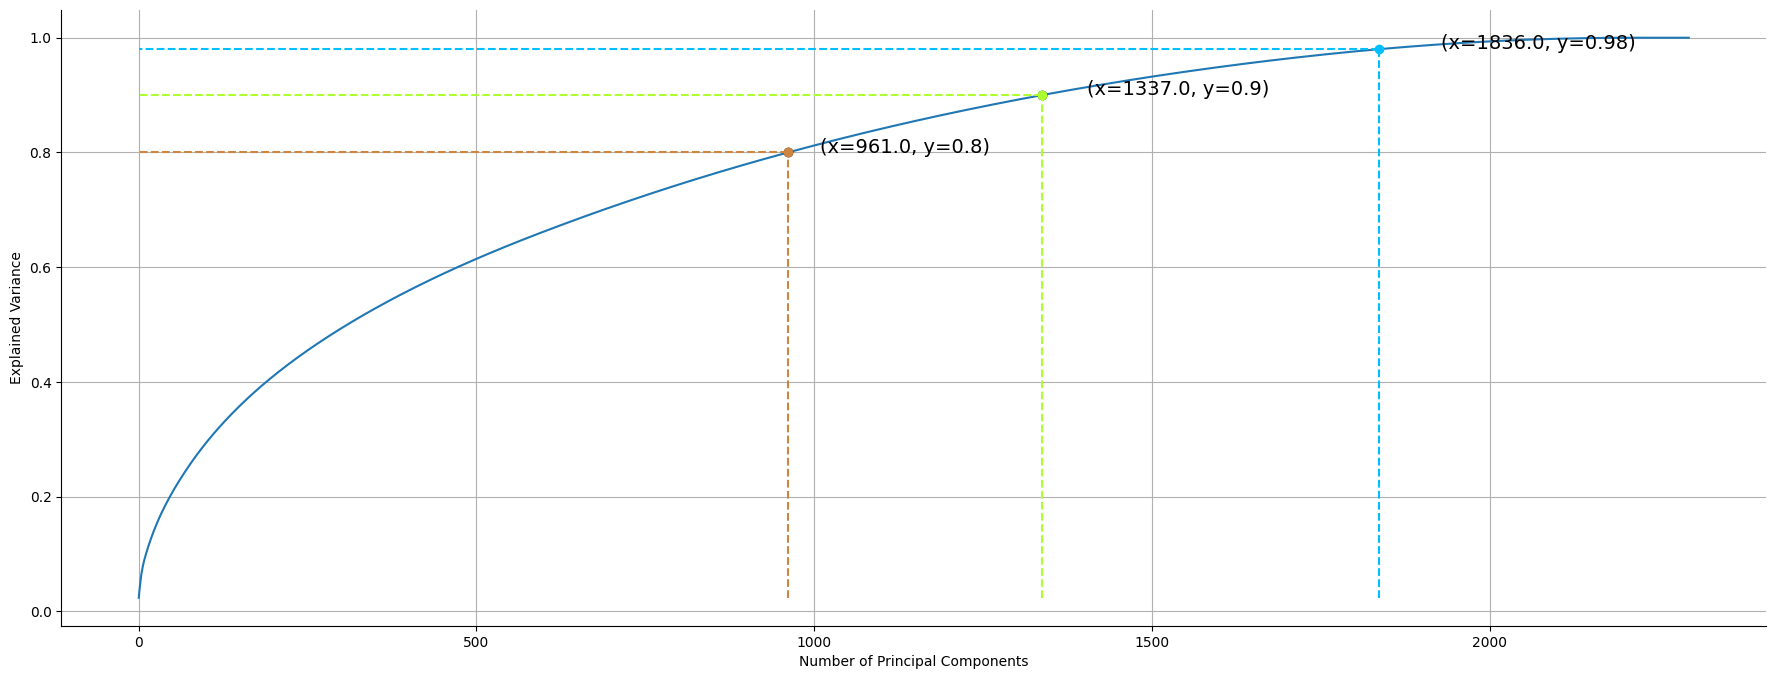

In [112]:
# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
fig, ax = plt.subplots(figsize=(22, 8))
plt.plot(x, y)
plt.plot(np.round(np.interp(0.8, y, x)), 0.8, 'o', color='k')
plt.plot(np.round(np.interp(0.9, y, x)), 0.9, 'o', color='k')
y_values=[0.8, 0.9, 0.98]
x_values=[np.round(np.interp(0.8, y, x)), np.round(np.interp(0.9, y, x)), np.round(np.interp(0.98, y, x))]
colors=['peru', 'greenyellow', 'deepskyblue']
for i in range(len(y_values)):
   plt.plot(x_values[i], y_values[i], 'o', color=colors[i])
   ax.annotate(f'(x={x_values[i]}, y={y_values[i]})', (x_values[i], y_values[i]), size=14, xytext=(x_values[i] * 1.05, y_values[i]))
   plt.plot([x_values[i], x[0]], [y_values[i], y_values[i]], '--', color=colors[i])
   plt.plot([x_values[i], x_values[i]], [y[0], y_values[i]], '--', color=colors[i])

plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();

we use *2227* feature for 0.98% of variation

In [113]:
from sklearn.decomposition import PCA

pca = PCA(n_components=961).fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

## Model Training

#### XGBoost

###### Base Model

In [114]:
base_xg_model = XGBClassifier()
base_xg_model.fit(X_train, y_train)
pred_labels = base_xg_model.predict(X_test)

print('base xgboost test AUC : ', roc_auc_score(y_test, pred_labels))
print('base xgboost test ACCURACY : ', accuracy_score(y_test, pred_labels))
print('base xgboost test F1 : ', f1_score(y_test, pred_labels, average='weighted'))

base xgboost test AUC :  0.6354558260136196
base xgboost test ACCURACY :  0.7298050139275766
base xgboost test F1 :  0.7084333784427204


###### testing for overfitting

In [115]:
from sklearn.model_selection import cross_validate
scores = {
    'auc' : make_scorer(roc_auc_score),
    'acc' : make_scorer(accuracy_score),
    'f1'  : make_scorer(f1_score, average='weighted'),
    }

cv_results = cross_validate(XGBClassifier(), X_train, y_train, cv=5, scoring=scores, return_train_score=True)
cv_results

{'fit_time': array([35.86472297, 25.59403157, 31.45709205, 26.82062483, 26.93994117]),
 'score_time': array([0.03699541, 0.03020787, 0.00874186, 0.0083077 , 0.01511168]),
 'test_auc': array([0.64305034, 0.63895234, 0.65858774, 0.65170217, 0.65572892]),
 'train_auc': array([1., 1., 1., 1., 1.]),
 'test_acc': array([0.74782609, 0.7167756 , 0.73856209, 0.74945534, 0.74727669]),
 'train_acc': array([1., 1., 1., 1., 1.]),
 'test_f1': array([0.71953021, 0.70438235, 0.72461853, 0.72610948, 0.72667116]),
 'train_f1': array([1., 1., 1., 1., 1.])}

###### grid search for best hyperparameters

In [116]:
from sklearn.model_selection import GridSearchCV

xg_params = {
    
    'max_depth': [3, 4, 5],
    'eta' : [0.01, 0.05, 0.1],
    'n_estimators' : [10, 20, 50]
}
clf = GridSearchCV(XGBClassifier(), xg_params, cv=5, return_train_score=True, scoring=scores, refit='auc', n_jobs=-1)
clf.fit(X_train, y_train)


print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n",clf.best_score_)
print("\n The best parameters across ALL searched params:\n",clf.best_params_)

 Results from Grid Search 

 The best score across ALL searched params:
 0.6419105082184868

 The best parameters across ALL searched params:
 {'eta': 0.1, 'max_depth': 4, 'n_estimators': 50}


###### best model from grid search

In [118]:
from sklearn.model_selection import cross_validate
scores = {
    'auc' : make_scorer(roc_auc_score),
    'acc' : make_scorer(accuracy_score),
    'f1'  : make_scorer(f1_score, average='weighted'),
    }

cv_results = cross_validate(XGBClassifier(eta= 0.1, max_depth= 4, n_estimators= 50, verbosity=0), X_train, y_train, cv=5, scoring=scores, return_train_score=True)
cv_results

{'fit_time': array([14.07441688, 30.03490758, 12.17365742, 19.20987105, 13.49352312]),
 'score_time': array([0.01533222, 0.05773377, 0.00763202, 0.00762105, 0.04052162]),
 'test_auc': array([0.66359829, 0.6081924 , 0.64320228, 0.64454206, 0.65001751]),
 'train_auc': array([0.95147259, 0.95928588, 0.95882518, 0.95029641, 0.95325912]),
 'test_acc': array([0.76086957, 0.71023965, 0.72766885, 0.74727669, 0.74945534]),
 'train_acc': array([0.96840959, 0.97332608, 0.97332608, 0.96733805, 0.96897115]),
 'test_f1': array([0.73732304, 0.68447395, 0.71176352, 0.720917  , 0.72426349]),
 'train_f1': array([0.96799022, 0.97303912, 0.97302463, 0.96690584, 0.96860212])}

In [120]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    skf_x_train, skf_y_train = X_train[train_index-1], y_train[train_index-1]
    skf_x_valid, skf_y_valid = X_train[valid_index-1], y_train[valid_index-1]

    xgb_model = XGBClassifier(eta= 0.1, max_depth= 4, n_estimators= 50, verbosity=0, early_stopping_rounds=10, eval_metric="logloss")
    xgb_model.fit(skf_x_train, skf_y_train, eval_set=[(skf_x_valid, skf_y_valid)], verbose=False)
    pred_labels = xgb_model.predict(skf_x_valid)

    print(f'{i} --- base xgboost test AUC : ', roc_auc_score(skf_y_valid, pred_labels))
    print(f'{i} --- base xgboost test ACCURACY : ', accuracy_score(skf_y_valid, pred_labels))
    print(f'{i} --- base xgboost test F1 : ', f1_score(skf_y_valid, pred_labels, average='weighted'))

0 --- base xgboost test AUC :  0.6246939180693124
0 --- base xgboost test ACCURACY :  0.7260869565217392
0 --- base xgboost test F1 :  0.7027261544159469
1 --- base xgboost test AUC :  0.643452380952381
1 --- base xgboost test ACCURACY :  0.7538126361655774
1 --- base xgboost test F1 :  0.7235648629644645
2 --- base xgboost test AUC :  0.6404244489687527
2 --- base xgboost test ACCURACY :  0.7342047930283224
2 --- base xgboost test F1 :  0.7147753188344864
3 --- base xgboost test AUC :  0.6374743995531559
3 --- base xgboost test ACCURACY :  0.7538126361655774
3 --- base xgboost test F1 :  0.7317991353064517
4 --- base xgboost test AUC :  0.6295283523171183
4 --- base xgboost test ACCURACY :  0.7037037037037037
4 --- base xgboost test F1 :  0.6767301667226139


In [128]:
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xg_model = XGBClassifier(eta= 0.1, max_depth= 4, n_estimators= 50, verbosity=0, early_stopping_rounds=15, eval_metric=["error", "logloss"])
best_xg_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
pred_labels = best_xg_model.predict(X_test)

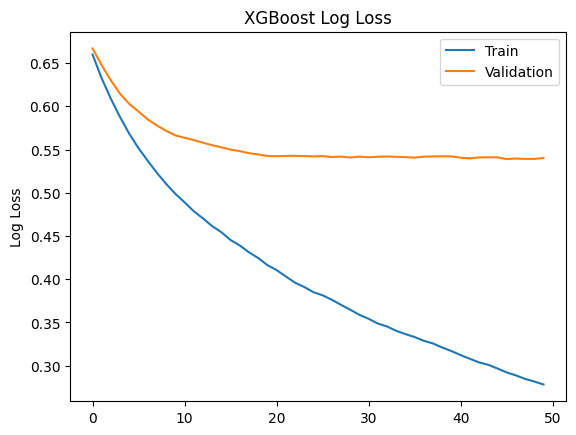

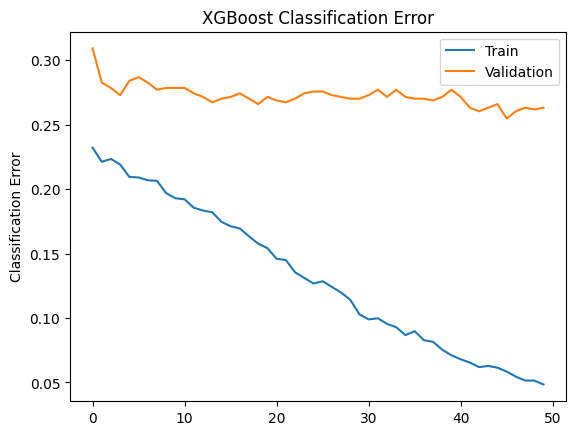

In [130]:
# retrieve performance metrics
results = best_xg_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       491
           1       0.67      0.34      0.45       227

    accuracy                           0.74       718
   macro avg       0.71      0.63      0.64       718
weighted avg       0.73      0.74      0.71       718



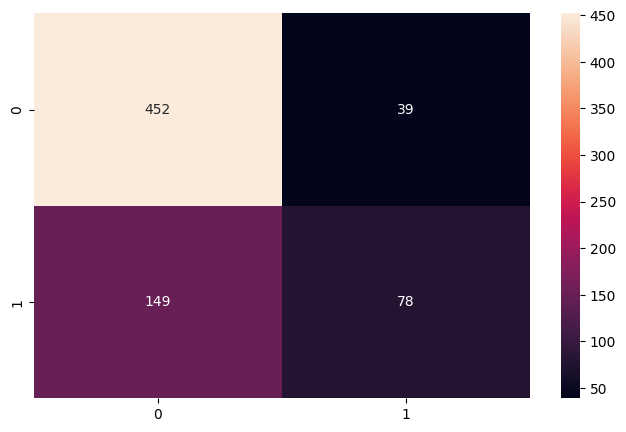

In [123]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='g')
print(classification_report(y_test, pred_labels))

#### using Optuna to find optimal hyperParams

In [ ]:
n_zeros = np.count_nonzero(y_train==0)
n_ones = np.count_nonzero(y_train==1)
print(n_zeros/n_ones)

2.1584158415841586


In [ ]:
def objective(trial):
# params specifies the XGBoost hyperparameters to be tuned
    params = {        
        "n_estimators": trial.suggest_int("n_estimators", 1, 50, step=1),
        "max_depth":trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True), 
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 10.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10.),
    }    
    
    model = XGBClassifier(
        **params,
        n_jobs=-1, 
        objective="binary:logistic",
        tree_method='gpu_hist', 
        gpu_id=0,
        scale_pos_weight=2.158
        
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    pred_labels = np.rint(preds)
# trials will be evaluated based on their accuracy on the test set
    auc = roc_auc_score(y_test, pred_labels)
    return auc

In [ ]:
storage_name = "sqlite:////content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/Codes /{}.db".format('xgboost_optimization')
study = optuna.create_study(direction="maximize", storage=storage_name,
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(),
                            load_if_exists=False)
study.optimize(objective, n_trials=250)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(" Value: {}".format(trial.value))
print(" Params: ")
for key, value in trial.params.items():
        print("\t {}: {}".format(key, value))

FastText

In [ ]:
train, test = train_test_split(data, test_size = 0.2, random_state=42, stratify=data.label)

print(f'Train data shape for semi_supervised learning : {train.shape}')
print(f'Test data shape for semi_supervised learning : {test.shape}')

Train data shape for semi_supervised learning : (2871, 4)
Test data shape for semi_supervised learning : (718, 4)


In [ ]:
ft_train_data = pd.DataFrame()
ft_train_data['label'] = "__label__" + train['label'].astype('str')
ft_train_data['fasttext_input'] =ft_train_data['label'] + ' ' + train['text'] 
print(ft_train_data.shape)
ft_train_data.head()

(2871, 2)


,label,fasttext_input
id,,
132226634,__label__1,__label__1 واقعاً بده 😡 ارزشش رو نداره نصب کنی...
131418101,__label__0,__label__0 یکم چشتونو باز کنین می بینین عالی
131980750,__label__1,__label__1 خیلی سوال هلش سخته تو عمو بهادر روز...
131279360,__label__0,__label__0 عالیییییییی حرف نداره خدای جدابیته ...
131531706,__label__1,__label__1 چراکرایه پایین هست این درآمدفقط برا...


In [ ]:
ft_test_data = pd.DataFrame()
ft_test_data['label'] = "__label__" + test['label'].astype('str')
ft_test_data['fasttext_input'] =ft_test_data['label'] + ' ' + test['text']
ft_test_data['text'] =  test['text']
print(ft_test_data.shape)
ft_test_data.head()

(718, 3)


,label,fasttext_input,text
id,,,
131607001,__label__1,__label__1 ببینید این واتساپ بدرد نمیخوره یه س...,ببینید این واتساپ بدرد نمیخوره یه ستاره هم برا...
132023684,__label__0,__label__0 ب زور ۱۰۰۰ تا سکه جمه کردم بازی تیم...,ب زور ۱۰۰۰ تا سکه جمه کردم بازی تیمی زدم رفت ا...
132712691,__label__0,__label__0 بزرگه چرا بزرگ نیست الان تو مپ برمو...,بزرگه چرا بزرگ نیست الان تو مپ برمودا یک هیولا...
131623032,__label__0,__label__0 هیچ وقت نیازی نیست جعبه لایتنر بخری...,هیچ وقت نیازی نیست جعبه لایتنر بخرید و یا حتی ...
131585289,__label__1,__label__1 حیف کع فیلتر میشه وگرنه خوبع,حیف کع فیلتر میشه وگرنه خوبع


In [ ]:
ft_train_data.to_csv("comment.train", columns=['fasttext_input'], index=False, header=False)
ft_test_data.to_csv("comment.test", columns=['fasttext_input'], index=False, header=False)

In [ ]:
ft_model = fasttext.train_supervised(input='comment.train', epoch=50, lr=0.01)
ft_model.test("comment.test")

(716, 0.770949720670391, 0.770949720670391)

In [ ]:
ft_test_data['ft_label'] = ft_test_data.text.apply(lambda x : ft_model.predict(x)[0][0])
ft_test_data['ft_label'] = ft_test_data.ft_label.apply(lambda x : 1 if x=='__label__1' else 0)
ft_test_data.head()

,label,fasttext_input,text,ft_label
id,,,,
131607001,__label__1,__label__1 ببینید این واتساپ بدرد نمیخوره یه س...,ببینید این واتساپ بدرد نمیخوره یه ستاره هم برا...,0
132023684,__label__0,__label__0 ب زور ۱۰۰۰ تا سکه جمه کردم بازی تیم...,ب زور ۱۰۰۰ تا سکه جمه کردم بازی تیمی زدم رفت ا...,1
132712691,__label__0,__label__0 بزرگه چرا بزرگ نیست الان تو مپ برمو...,بزرگه چرا بزرگ نیست الان تو مپ برمودا یک هیولا...,0
131623032,__label__0,__label__0 هیچ وقت نیازی نیست جعبه لایتنر بخری...,هیچ وقت نیازی نیست جعبه لایتنر بخرید و یا حتی ...,0
131585289,__label__1,__label__1 حیف کع فیلتر میشه وگرنه خوبع,حیف کع فیلتر میشه وگرنه خوبع,0


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       491
           1       0.67      0.53      0.59       227

    accuracy                           0.77       718
   macro avg       0.74      0.71      0.72       718
weighted avg       0.76      0.77      0.76       718



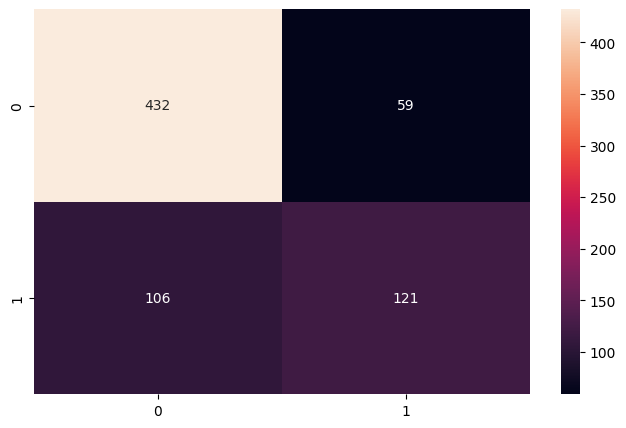

In [ ]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test,   ft_test_data.ft_label), annot=True, fmt='g')
print(classification_report(y_test, ft_test_data.ft_label))